In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [0]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

dataloader = torch.utils.data.DataLoader(mnist_train, 100, shuffle=True, drop_last=True)

In [11]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [27]:
mnist_train.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

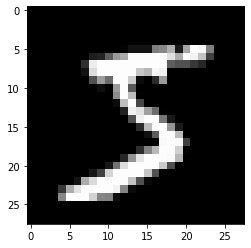

In [17]:
import matplotlib.pyplot as plt

plt.imshow(mnist_train.data[0], cmap='gray')
plt.show()

In [21]:
a = nn.Linear(2,2)
x = torch.FloatTensor([[1,2]])
print(a(x))

tensor([[ 0.0737, -0.8053]], grad_fn=<AddmmBackward>)


In [30]:
layer = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)          
)
x = torch.FloatTensor([mnist_train.data[0]])
print(layer(x))

ValueError: ignored

In [0]:
# 28*28
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()

            # 28-28-32
            # 14-14-32
        ).to(device)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()

            # 14-14-64
            # 7-7-64
        ).to(device)
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 32),
            nn.Linear(32, 10)
        ).to(device)

    def forward(self, x):
        return self.fc(self.layer2(self.layer1(x)).view(-1,7*7*64).to(device))

In [57]:
epochs = 10

model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    
    all_loss = 0

    for idx, mini_batch in enumerate(dataloader):
        x_train, y_train = mini_batch
        
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        pred = model(x_train).to(device)
        loss = F.cross_entropy(pred, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_loss += loss.item()

    if epoch % 1 == 0:
        print(epoch, all_loss)

0 121.8702078834176
1 48.55630015069619
2 43.384256788063794
3 40.1130810554605
4 39.53545119287446
5 38.55665679188678
6 37.36983384611085
7 36.45933275739662
8 33.329810900846496
9 34.07645596470684


tensor([-4.6900, 14.9637,  0.6411, -3.8470,  3.5869, -3.3491, -2.2588,  1.4849,
         0.7116, -3.8316], device='cuda:0')
tensor(1, device='cuda:0')


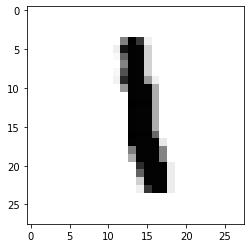

In [66]:
model.eval()
x_train, y_train = dataloader.dataset[6]
data = model(x_train.view(-1, 1, 28, 28).to(device)).detach()[0]
print(data)
print(torch.argmax(data))
plt.imshow(x_train[0], cmap='Greys')
plt.show()

In [68]:
import numpy as np
dataloader = torch.utils.data.DataLoader(mnist_train, 100, shuffle=True, drop_last=True)
model.eval()


with torch.no_grad():
    tmp = []
    for data in dataloader:
        x_data, y_data = data
        pred = model(x_data.view(-1, 1, 28, 28).float().to(device))
        tmp.append((y_data.to(device) == torch.argmax(pred, 1)).float().mean().item())
    print('Train Accuracy : %.2f%%'%(np.array(tmp).mean()*100))

Train Accuracy : 98.33%


In [73]:
(torch.FloatTensor([1,2,3,4]) == torch.FloatTensor([1,3,3,4])).float().mean()

tensor(0.7500)